## Part-3 
## Transfer learning using state-of-art model (MobileNetV2)

#### Dataset used in this project is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. 
#### However, this project is scoped to recognizing 3 facial attributes : 1) Heavy Makeup 2) Male 3) Smiling

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, LeakyReLU
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers

### Following same steps as part -1 to uplaod images and its corresponding labels

In [4]:
data = pd.read_csv("list_attr_celeba.csv", usecols=['image_id','Male','Heavy_Makeup','Smiling'])


img_width = 224
img_height = 224
data = data[:2000]

In [5]:
X = []
for i in tqdm(range(data.shape[0])):
    path = '/img_align_celeba/images/' + data['image_id'][i]
    img = image.load_img(path, target_size=(img_width, img_height, 3))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)
    
X = np.array(X)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 144.97it/s]


In [6]:
y = []
for i in tqdm(range(data.shape[0])):
    row = data.iloc[i].values
    row = row[1:]
    y.append(row)
    
y = np.array(y)
y = np.asarray(y).astype('float32')

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4686.76it/s]


#### Splting data into train and test set

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state=46)

Transfer Learning means transfering knowledge of one model to the current model.
This provide several benefits:
    
    1) Saves time and provide high efficiency
    
    2) Engineers can try many different models and hyper-parameter which leads to better results.
    
    3) Less processing leads to positive effect on environment.  

Using the MobileNetV2 (State-of-art model) to do transfer learning

Excluding dense-layers of MobileNetV2 and merging own dense layers on top of MobileNetV2 layers

In [10]:

#Apply Preprocessing steps on training data as per Mobilenet_V2
X_train = tf.keras.applications.mobilenet_v2.preprocess_input(
    X_train, data_format=None
)

#Apply Preprocessing steps on testing data as per Mobilenet_V2

X_test = tf.keras.applications.mobilenet_v2.preprocess_input(
    X_test, data_format=None
)


base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights = 'imagenet',
    input_shape = (X_train.shape[1:]),
    include_top= False
    )

# 'base_model.trainable = False' because MobileNet layers are already trained on large image dataset
# Therefore, no need to trained weights of MobileNetV2 layers again
base_model.trainable = False

In [73]:
#Merging own dense layers to MobileNetV2 model

top_model = base_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(3, activation='sigmoid')(top_model)
    
# Group the convolutional base and new fully-connected layers into a Model object.
model = Model(inputs=base_model.input, outputs=output_layer)

In [74]:
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [76]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
44/44 [==============================] - 29s 672ms/step - loss: -22742.7617 - accuracy: 0.4000 - val_loss: -26752.6738 - val_accuracy: 0.4133
Epoch 2/10
44/44 [==============================] - 35s 797ms/step - loss: -30577.5879 - accuracy: 0.4086 - val_loss: -35284.8477 - val_accuracy: 0.4167
Epoch 3/10
44/44 [==============================] - 33s 751ms/step - loss: -39373.4688 - accuracy: 0.4136 - val_loss: -44898.3047 - val_accuracy: 0.4150
Epoch 4/10
44/44 [==============================] - 33s 746ms/step - loss: -49270.3828 - accuracy: 0.4043 - val_loss: -55581.1094 - val_accuracy: 0.4217
Epoch 5/10
44/44 [==============================] - 33s 754ms/step - loss: -60314.7305 - accuracy: 0.4100 - val_loss: -67484.7500 - val_accuracy: 0.4250
Epoch 6/10
44/44 [==============================] - 33s 767ms/step - loss: -72779.9688 - accuracy: 0.4186 - val_loss: -80550.4297 - val_accuracy: 0.4283
Epoch 7/10
44/44 [==============================] - 35s 800ms/step - loss: -86282.

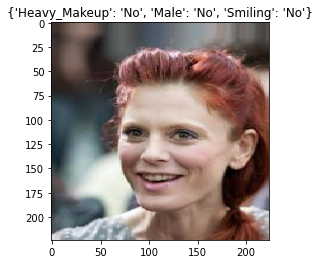

In [63]:
#Prediction
path = '/img_align_celeba/images/000002.jpg'
img = image.load_img(path, target_size=(img_width, img_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0

img = img.reshape(1 , img_width, img_height, 3)
classes = data.columns[1:]

y_pred = model.predict(img)

res = {}
for i in range(y_pred.shape[1]):
    if y_pred[0][i] > 0.70:
        res[classes[i]] = 'Yes'
    else:
        res[classes[i]] = 'No'
        
plt.imshow(img.reshape(img_width, img_height,3))
plt.title(res)
plt.show()

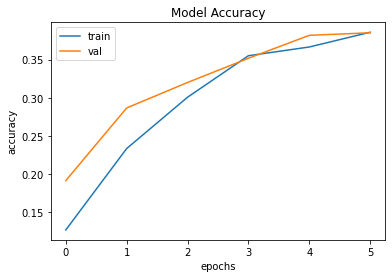

In [65]:
#1. Display (plot) the Training Vs Validation Accuracy of the CNN Model as a line graph using matplotlib.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

It can be noticed that transfer learning helped to train the model efficiently. However, in this case it does not provide higher accuracy than model created from scretch with data augmentation 